**Implementation of the Toy Navigational Model**

Here I implement the basic 1D navigator model starting at (0,1) and moving downwards to a home at (0,0). I consider two types of agents: one flying as fixed pair and developing a shared memorized route (CM) and other a combination of two individuals having formed their own idiosyncratic route and flown together as a shuffled pair (CI). The pairs can exist in any of the four information states: 00, 10, 01 and 11 out of which only the 00 state is of the lowest information. The fixed pair condition only has states 10 or 01 as either bird leads (or knows about the landscape) at any point of time. On the other hand, the shuffled pair condition can have all the four possible states with probabiltiy of having the 00 state 0.25. The agents work by sampling next headings as a weighted sum of their bearing towards home from the current position and their currently followed heading. This weighting is adjusted dynamically based on the posiiton of the agent from home with increased weight to the home vector as the agent approaches closer to home. I have implemented some termination conditions: the simulation ends when the agents go past home site (i.e. beyond (0,0) or y < 0) or if they fly in the wrong direction upwards from the start. Once the weighted new heaidng is calculated the agent moves towards it with some noise scaled by the variance of the information state for the condition with specified probability. Here is an illustration of the model:




In [958]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Main Simulation function
def simulate_density(
    max_steps=200,
    step_size=0.1,
    sigma_less=0.6,          # high uncertainty
    sigma_more=0.2,     # low uncertainty
    P_less=0.25
):
    """
    Movement decisions:
        - Bird moves using heading that is blend of previous heading and home vector
        - Noise variance chosen using P_less for less or more route knowledge
        - Home attraction increases as bird gets closer to home
    """

    # Preallocate arrays
    x = np.full(max_steps + 1, np.nan)
    y = np.full(max_steps + 1, np.nan)
    w = np.full(max_steps + 1, np.nan)
    heading = np.full(max_steps + 1, np.nan)

    # Starting position
    x[0] = 0
    y[0] = 1
    w[0] = 0 #Intial weight for homing is 0

    # Choose noise variance based on P_less i.e probability of less informed states (1/4th by default)
    sigma_noise = np.random.choice(
        [sigma_less, sigma_more],
        p=[P_less, 1 - P_less]
    )

    # Sample a heading with the bearing towards home to set initial direction downwards and with the specified sigma
    heading[0] = np.random.normal(0, sigma_noise)

    # --- first step ---
    x[1] = x[0] + step_size * np.sin(heading[0])
    y[1] = y[0] - step_size * np.cos(heading[0]) # Subtract cause we are going downwards in the y direction

    # Calculate beeline distance to home
    d_bee = np.sqrt(x[0]**2 + y[0]**2)

    # Main loop to move
    i = 1
    while i < max_steps:

        # Stop condition when going past home
        if y[i] <= 0:
            break
        
        # If agent goes beyond start in the opposite direction just exclude that run
        if y[i] >= 1:
            return pd.DataFrame()
        # Compute ideal pull vector toward home
        home_vec_angle = np.arctan2(-x[i], y[i]) #this -dx/dy as we have angle reference from -ve y axis

        # Compute distance from current point to (0,0)
        d = np.sqrt(x[i]**2 + y[i]**2)

        # Compute dynamic weight towards home
        w[i] = max(0, min(1, 1 - (d / d_bee)))  # clamp to [0,1]

        # Blend current heading direction and home vector from current point weighted according to distance from home site (closer to home put more wieght on home vector)
        target_heading = (1 - w[i]) * heading[i - 1] + w[i] * home_vec_angle

        # Choose noise variance based on P_less
        sigma_noise = np.random.choice(
            [sigma_less, sigma_more],
            p=[P_less, 1 - P_less]
        )

        new_heading = np.random.normal(target_heading, sigma_noise)
        

        # Update next x/y positions
        x[i + 1] = x[i] + step_size * np.sin(new_heading)
        y[i + 1] = y[i] - step_size * np.cos(new_heading)

        # Update the current heading and increment
        heading[i] = new_heading
        i += 1

    # trim output to i + 1 steps (once the agent goes beyond the home) 
    
    return pd.DataFrame({
        "step": np.arange(i+1),
        "x": x[:i+1],
        "y": y[:i+1],
        "heading": heading[:i+1],
        "weight": w[:i+1]
    })

# Calculate the route efficiency of trajectories
def calculate_route_efficiency(df, beeline_distance = 1):
    total_distance = np.nansum(
        np.sqrt(df["x"].diff()**2 + df["y"].diff()**2)
    )
    return(beeline_distance/total_distance)

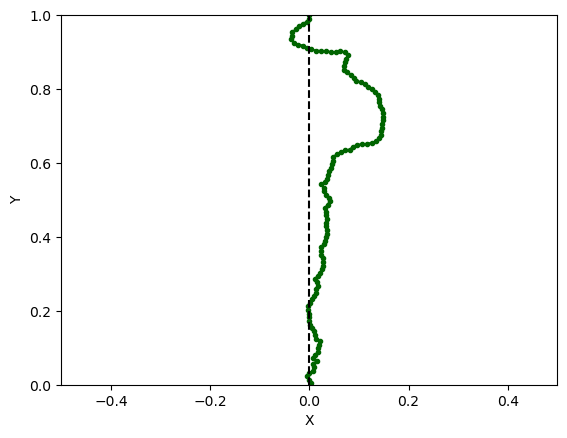

In [1047]:
result = simulate_density(max_steps= 300, step_size=0.01, P_less=0.25, sigma_less=0.6, sigma_more=0.3)

plt.figure()
plt.plot(result["x"], result["y"], "-o", color="darkgreen", markersize=3)
plt.axvline(0, linestyle="--", color="black")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-0.5,0.5])
plt.ylim([0, 1])
plt.show()

In [926]:
# Compute replicates 
def generate_replicates(
        sims=10000,
        step_size=0.01,
        s_more = 0.6,
        s_less = 0.3,
        max_steps = 300
):
    stable_eff = [] # Store stable efficiencies
    unstable_eff = [] # Store unstable efficiencies

    stable_traj = []      # Store stable trajectories
    unstable_traj = []    # Store unstable trajectories

   

    # Run stable (P_less = 0) sims
    sim_counter = 0 # replicate id
    while len(stable_eff) < sims:
        df = simulate_density(P_less=0, step_size=step_size, sigma_less=s_less, sigma_more=s_more, max_steps = max_steps)

        if df.empty:
            continue  # skip invalid run
        # Assign simulation id
        sim_counter += 1                       
        df["sim_id"] = sim_counter  

        stable_eff.append(calculate_route_efficiency(df))
        stable_traj.append(df)  

    # Run unstable (P_less = 0.25) sims 
    sim_counter = 0 # replicate id
    while len(unstable_eff) < sims:
        df = simulate_density(P_less=0.25, step_size=step_size, sigma_less=s_less, sigma_more=s_more, max_steps = max_steps)

        if df.empty:
            continue  # skip invalid run

        # Assign simulation id
        sim_counter += 1                       
        df["sim_id"] = sim_counter  

        unstable_eff.append(calculate_route_efficiency(df))
        unstable_traj.append(df) 

    return (
        np.array(stable_eff),
        np.array(unstable_eff),
        stable_traj,
        unstable_traj
    )

# Run replicates
np.random.seed(123)
stable_eff, unstable_eff, stable_traj, unstable_traj = generate_replicates(sims = 10000, s_more=0.3, s_less=0.6, max_steps=400, step_size = 0.01)


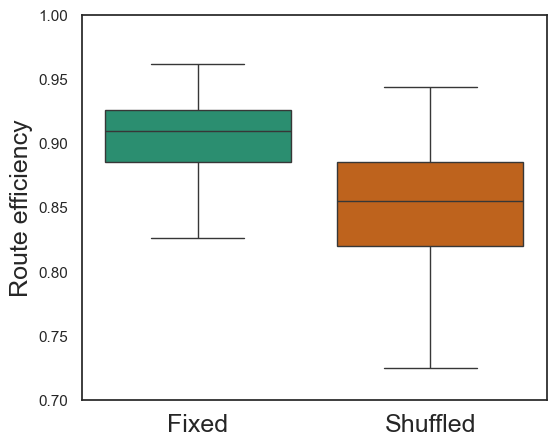

In [1061]:
# Plot the replicate results

plt.figure(figsize=(6,5))
sns.set_style("white")  

sns.boxplot(
    data=[stable_eff, unstable_eff],
    showfliers=False,
    palette=["#1b9e77", "#d95f02"]  
)
plt.xticks([0, 1], ["Fixed", "Shuffled"], fontsize=18)
plt.ylim((0.7, 1))
plt.ylabel("Route efficiency", fontsize=18)
#plt.title("Route efficiency distribution for fixed and shuffled pairs", fontsize = 16)
plt.show()


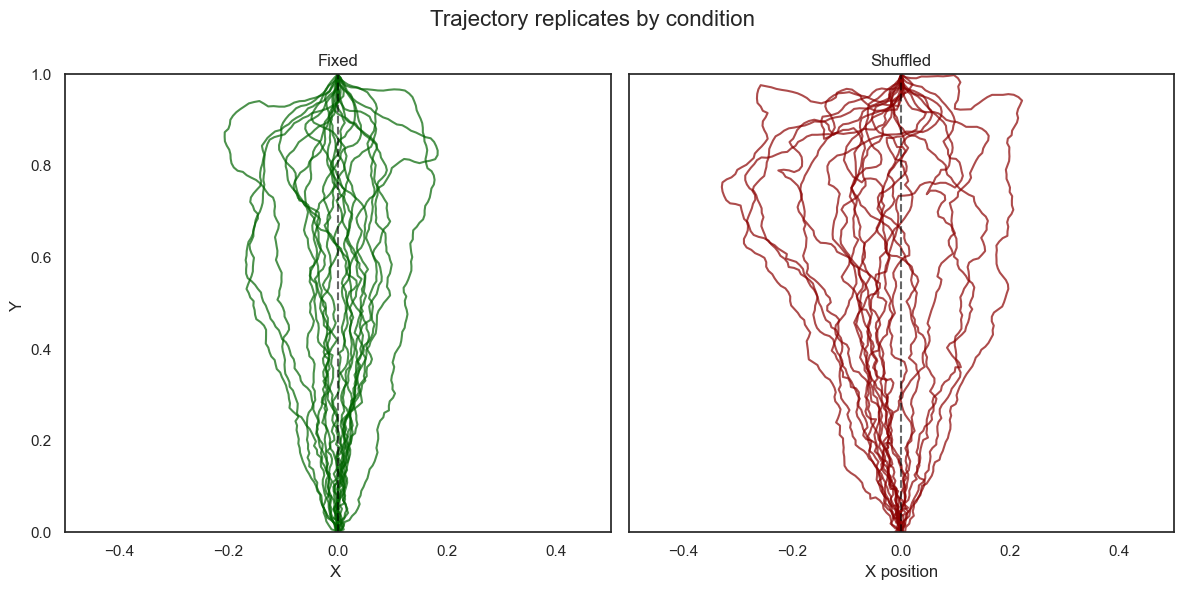

In [1062]:
# Plot trajectories generated from both conditions

def plot_replicate_tracks(stable_traj, unstable_traj, n_to_plot=10):
    """
    Plots replicate tracks side by side for stable vs unstable conditions.
    Uses stored trajectory DataFrames from compute_efficiencies_and_trajectories().
    """

    # select first N trajectories (limits clutter)
    stable_subset = stable_traj[:n_to_plot]
    unstable_subset = unstable_traj[:n_to_plot]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    # ---- STABLE CONDITION ----
    ax = axes[0]
    for df in stable_subset:
        ax.plot(df["x"], df["y"], "-", linewidth=1.5, alpha=0.7, color="darkgreen")

    ax.axvline(0, linestyle="--", color="black", alpha=0.6)
    ax.set_title("Fixed")
    ax.set_xlabel("X ")
    ax.set_ylabel("Y ")
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylim([0, 1])

    # ---- UNSTABLE CONDITION ----
    ax = axes[1]
    for df in unstable_subset:
        ax.plot(df["x"], df["y"], "-", linewidth=1.5, alpha=0.7, color="darkred")

    ax.axvline(0, linestyle="--", color="black", alpha=0.6)
    ax.set_title("Shuffled")
    ax.set_xlabel("X position")
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylim([0, 1])

    fig.suptitle("Trajectory replicates by condition", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_replicate_tracks(stable_traj, unstable_traj, n_to_plot=20)


In [ ]:
def extract_step_1(traj_list):
    """
    Extracts the first step deviation for a trajectory list
    """
    rows = []
    for df in traj_list:
        # filter step = 1
        step1 = df[df["step"] == 1].copy()

        if not step1.empty:
            rows.append(step1)

    return pd.concat(rows, ignore_index=True)

stable_step1 = extract_step_1(stable_traj)
unstable_step1 = extract_step_1(unstable_traj)

def cumulative_x_deviation(df):
    """
    Calculates cumulative sum of absolute lateral deviation (|x|),
    EXCLUDING the first step.
    """
    # drop the first step 
    df_no_first = df.iloc[1:]  
    
    # sum abs(x)
    return df_no_first["x"].abs().sum()

stable_cum_dev = [
    cumulative_x_deviation(df) for df in stable_traj
]

unstable_cum_dev = [
    cumulative_x_deviation(df) for df in unstable_traj
]


In [ ]:
# Combine for plotting
stable_df = pd.DataFrame({
    "initial_x": abs(stable_step1["x"].values),
    "cum_dev": stable_cum_dev,
    "condition": "Fixed"
})

unstable_df = pd.DataFrame({
    "initial_x": abs(unstable_step1["x"].values),
    "cum_dev": unstable_cum_dev,
    "condition": "Shuffled"
})

combined_df = pd.concat([stable_df, unstable_df], ignore_index=True)


In [ ]:
# Utility to remove outliers if present
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]
stable_clean = remove_outliers(
    combined_df[combined_df["condition"] == "Fixed"], "cum_dev"
)

unstable_clean = remove_outliers(
    combined_df[combined_df["condition"] == "Shuffled"], "cum_dev"
)


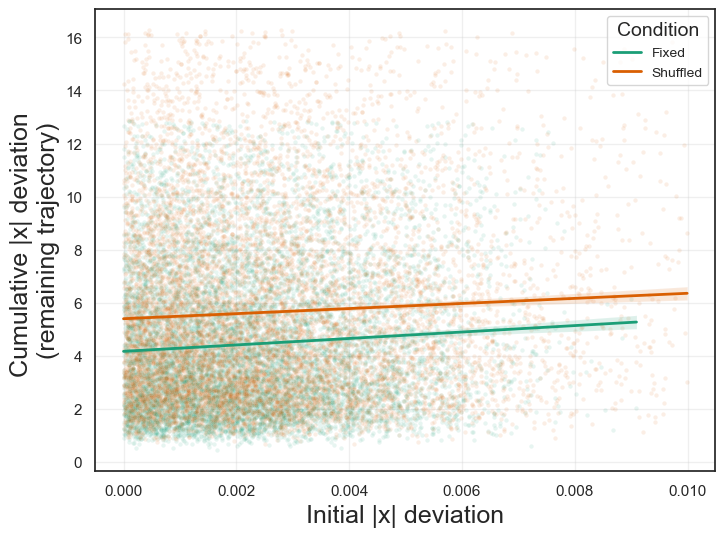

In [ ]:
plt.figure(figsize=(8,6))

# ---- scatter points ----
sns.scatterplot(
    data=stable_clean,
    x="initial_x",
    y="cum_dev",
    alpha=0.1,
    s=10,
    color="#1b9e77"
)

sns.scatterplot(
    data=unstable_clean,
    x="initial_x",
    y="cum_dev",
    alpha=0.1,
    s=10,
    color="#d95f02"
)

# ---- regression with ribbon----
sns.regplot(
    data=stable_clean,
    x="initial_x",
    y="cum_dev",
    scatter=False,
    ci=95,
    line_kws=dict(color="#1b9e77", linewidth=2),
    color="#d95f02",
    label="Fixed"
)

sns.regplot(
    data=unstable_clean,
    x="initial_x",
    y="cum_dev",
    scatter=False,
    ci=95,
    line_kws=dict(color="#d95f02", linewidth=2),
    color="#d95f02",
    label="Shuffled"
)

plt.xlabel("Initial |x| deviation", fontsize=18)
plt.ylabel("Cumulative |x| deviation \n(remaining trajectory)", fontsize=18)
plt.legend(title="Condition", fontsize=10, title_fontsize=14, loc="upper right")
plt.grid(alpha=0.3)
plt.show()
